<a href="https://colab.research.google.com/github/ankitstar01/Stock-Sentiment-Analysis/blob/master/Prediction_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install polygon-api-client
!pip install finnhub-python
!mkdir Data
!mkdir Data/Recent
!mkdir Data/Historic
!mkdir Models
!mkdir Scale

import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
import pprint
import time
import finnhub
import nltk

from textblob import TextBlob
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from polygon import RESTClient
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Activation
from keras.callbacks import EarlyStopping

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def get_historic_data(ticker, time_horizon, time_span, key):
    f = open('Data/Historic/' + time_span + ticker + '.csv', 'w')
    with RESTClient(key) as client:
        resp = []
        f.write('timestamp,open,low,high,volume,close\n')
        resp3 = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_='2020-07-29', to='2021-09-29', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp3 = resp3.results
        for query in resp3:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')

        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_='2020-09-29', to='2020-11-28', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
            
        resp2 = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_='2020-11-29', to='2021-02-19', unadjusted=False,
                                                 sort='asc', limit=50000)
        resp2 = resp2.results
        for query in resp2:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open('Data/Historic/' + time_span + ticker + '.csv', 'r')
    df = pd.read_csv(f)
    return df

In [ ]:
def preprocess_training_data(training_df):
    training_df = training_df.drop(['timestamp'], axis=1)
    scaler = MinMaxScaler()
    scaler_df = training_df.copy()
    scaler.fit_transform(scaler_df)
    scaler = scaler.scale_
    training_df['open'] *= scaler[0]
    training_df['low'] *= scaler[1]
    training_df['high'] *= scaler[2]
    training_df['volume'] *= scaler[3]
    training_df['close'] *= scaler[4]

    x_train, y_train = [], []
    training_df = np.asarray(training_df)
    for i in range(6, training_df.shape[0]):
        x_train.append(training_df[i - 6: i])
        y_train.append(training_df[i, 0])
    x_train, y_train,xv,yv , x_test,y_test = np.asarray(x_train[:-200]), np.asarray(y_train[:-200]),np.array(x_train[-200:-100]), np.array(y_train[-200:-100]),np.asarray(x_train[-100:]), np.asarray(y_train[-100:])
    return x_train, y_train,xv,yv,x_test,y_test, scaler

In [ ]:
def save_scaler(ticker):
    f = open('Scale/' + ticker + '.csv', 'w') 
    f.write(str(scaler[0]) + '\n')
    f.write(str(scaler[1]) + '\n')
    f.write(str(scaler[2]) + '\n')
    f.write(str(scaler[3]) + '\n')
    f.write(str(scaler[4]) + '\n')

In [ ]:
def get_recent_data(ticker, key, time_horizon, time_span):
    f = open('Data/Recent/' + time_span + ticker + '.csv', 'w')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_='2021-02-19', to=date, unadjusted=False,
                                                 sort='asc', limit=50000)
        resp = resp.results
        f.write('timestamp,open,low,high,volume,close\n')
        for query in resp:
            f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                    + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()

In [ ]:
def update_recent_data(ticker, key, time_horizon, time_span):
    f = open('Data/Recent/' + time_span + ticker + '.csv', 'a')
    with RESTClient(key) as client:
        resp = client.stocks_equities_aggregates(ticker=ticker, multiplier=time_horizon, timespan=time_span,
                                                 from_='2021-02-19', to=date, unadjusted=False,
                                                 sort='desc', limit=50000)
        query = resp.results[0]
        f.write(str(query['t']) + ',' + str(query['o']) + ',' + str(query['l']) + ','
                + str(query['h']) + ',' + str(query['v']) + ',' + str(query['c']) + '\n')
    f.close()
    f = open('Data/Recent/' + time_span + ticker + '.csv', 'r')
    entry_price = resp.results[4]['o']
    recent_df = pd.read_csv(f)[:-1]
    return recent_df, entry_price

In [ ]:
def preprocess_recent_data(recent_df, scaler):
    recent_df = recent_df.drop(['timestamp'], axis=1)
    recent_df['open'] *= scaler[0]
    recent_df['low'] *= scaler[1]
    recent_df['high'] *= scaler[2]
    recent_df['volume'] *= scaler[3]
    recent_df['close'] *= scaler[4]
    df = [recent_df[-6:]]
    df = np.asarray(df)
    return df

In [ ]:
def get_prediction(model, scaler, last_data):
    prediction = model.predict(last_data)
    prediction *= 1/scaler[0]
    return prediction

In [ ]:
def create_rnn(ticker, training_input, training_output,xv,yv):
    model = Sequential()

    model.add(LSTM(units=50,
                   activation='selu',
                   input_shape=(6, 6),
                   return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=60,
                   activation='selu',
                   return_sequences=True))
    
    model.add(Dropout(0.2))
    model.add(LSTM(units=80, 
                   activation='selu',
                   return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(units=100,
                   activation='selu',
                   return_sequences=False
                   ))
    model.add(Dropout(0.2))

    model.add(Dense(25))
    model.add(Dense(1))
    model.add(Activation('linear'))
    
    return model

In [ ]:
def train_model(model, training_input, training_output, xv, yv):
    model.compile(optimizer='adam', loss='mean_squared_error')
    es=EarlyStopping(monitor='val_loss',mode='min',patience=5,verbose=1)

    model.fit(
        training_input, training_output,validation_data=(xv,yv), 
        epochs=100, batch_size=24,verbose=1,callbacks=[es]
        )

In [ ]:
def visualize_model(predictions, answers, ticker):
    plt.figure(figsize=(15, 5))
    plt.plot(answers, c='r', label='Real' + ' ' + ticker + ' ' + 'Stock Price')
    plt.plot(predictions, c='c', label='Prediction' + ' ' + ticker + ' ' + 'Stock Price')
    plt.xlabel('time')
    plt.ylabel(ticker + ' ' + 'Stock Price')
    plt.legend()
    plt.show()

In [ ]:
def get_average(predictions, answer):
  difference = 0
  tests = 0
  for i in range(len(answers) - 1000, len(answers)):
      tests += 1
      difference += answers[i] - predictions[i][0]
  average = difference/tests
  return average

In [ ]:
def get_prev_difference(ticker, api_key):
    with RESTClient(api_key) as client:
        resp = client.stocks_equities_previous_close(ticker, unadjusted=False)
        resp = resp.results
        previous_close = resp['c']
        resp2 = client.stocks_equities_daily_open_close()
        todays_open = resp['open']
        difference = todays_open - previous_close
        return previous_close, todays_open, difference


In [ ]:
def r(x,y):
  if(y/x>1.5):
    return 1.5
  elif(y/x<-1.4):
    return (-1.4)
  else:
    return y/x

In [ ]:
def probablity(pred, y_test,recent_news_polarity):
    n = len(pred)
    prob = []
    for j in range(5, n):
        p = 50
        new_polarity_effect=0
        if(pred[i]>pred[i-1] and recent_news_polarity>0):
          np=15*recent_news_polarity
        elif(pred[i]<pred[i-1] and recent_news_polarity<0):
          np=-1*10*recent_news_polarity
        else:
          np=-1*10*recent_news_polarity

        for i in range(j-5, j):
            pp = (pred[i] - pred[i-1]) / pred[i-1]
            tp = (y_test[i] - y_test[i-1]) / y_test[i-1]
            if (r(pp, tp) <0 ):
                p = p+ (p) * (r(pp, tp) / 10)
            else:
                p = p + (100 - p) * (r(pp, tp) / 10)
            prob.append(p)
    return prob+np

In [ ]:
def get_prediction_details(ticker, key, time_horizon, time_span, prediction, entry_price):
    result = {  
        'Ticker': ticker,
        'Entry Price': entry_price,
        'Potential Target Price': prediction,
        'Profit': round(prediction / entry_price * 100 - 100, 3), 
        'Time Horizon': str(time_horizon) + ' ' + time_span + 's',
    }
    return result

In [ ]:
def get_news(ticker):
    client = finnhub.Client("c0opefv48v6rduk5oegg")
    resp = client.company_news('NIO', '2020-12-11', '2021-02-19')
    df = pd.DataFrame(resp)
    resp2 = client.company_news('NIO', '2020-11-02', '2020-12-11')
    df2 = pd.DataFrame(resp2)
    resp3 = client.company_news('NIO', '2020-09-27', '2020-11-02')
    df3 = pd.DataFrame(resp3)
    resp4 = client.company_news('NIO', '2020-07-27', '2020-09-27')
    df4 = pd.DataFrame(resp4)
    df0 = pd.concat([df, df2])
    df = pd.concat([df0, df3])
    df = pd.concat([df, df4])
    df['datetime'] = df['datetime'].apply(lambda x:datetime.fromtimestamp(x))
    df = df.drop(['url'], axis=1)
    df = df.drop(['id'], axis=1)
    df = df.drop(['image'], axis=1)
    df = df.drop(['source'], axis=1)
    df = df.drop(['related'], axis=1)
    df = df.drop(['category'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    df = df.iloc[::-1]
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    return df

In [ ]:
def get_recent_news(ticker):
    client = finnhub.Client("c0opefv48v6rduk5oegg")
    resp = client.company_news('NIO', '2021-02-19', '2021-02-24')
    df = pd.DataFrame(resp)
    df['datetime'] = df['datetime'].apply(lambda x:datetime.fromtimestamp(x))
    df = df.drop(['url'], axis=1)
    df = df.drop(['id'], axis=1)
    df = df.drop(['image'], axis=1)
    df = df.drop(['source'], axis=1)
    df = df.drop(['related'], axis=1)
    df = df.drop(['category'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    df = df.iloc[::-1]
    df = df.reset_index()
    df = df.drop(['index'], axis=1)
    return df

In [ ]:
def classify(classifier, document, words):
    document_words = extract_words(document)
    features = {
        word: (word in document_words)
        for word in words
    }
    return classifier.prob_classify(features)

In [ ]:
def generate_features(documents, words, label):
    features = []
    for document in documents:
        features.append(({
            word: (word in document)
            for word in words
        }, label))
    return features


In [ ]:
def extract_words(document):
    return set(
        word.lower() for word in nltk.word_tokenize(document)
        if any(c.isalpha() for c in word)
    )

In [ ]:
def get_polarity(headline):
    result = []
    for file in ["positives.txt", "negatives.txt"]:
        with open(file, 'r') as f:
            result.append([extract_words(line) for line in f.read().splitlines()])
    positives, negatives = result

    words = set()
    for document in positives:
        words.update(document)
    for document in negatives:
        words.update(document)

    training = []
    training.extend(generate_features(positives, words, "Positive"))
    training.extend(generate_features(negatives, words, "Negative"))

    classifier = nltk.NaiveBayesClassifier.train(training)
    result = (classify(classifier, headline, words))
    return result.prob("Positive")


In [ ]:
def combine_news_data(news_df, df):
    x = []
    j = 0
    n = len(df)
    f = 0
    for i in range(len(news_df)):
      p = 0
      c = 0
      while df['timestamp'].iloc[j] > news_df['datetime'].iloc[i]:
        p = get_polarity(news_df['headline'].iloc[i])
        c = c + 1
        i = i + 1
      if c > 0 :
        p = p / c
      while  df['timestamp'].iloc[j] < news_df['datetime'].iloc[i]:
        if c > 0:
          x.append(get_polarity(news_df['headline'].iloc[i]))
        else:
          x.append(p)
        j = j + 1
        if j == n:
          f = 1
          break
      if f == 1:
        break
    df = pd.DataFrame(np.array(x),columns=['polarity'])
    return df

In [ ]:
api_key = 'vqeohd8x5k1x6PKiisJQS8RgS3A1iRQC'
time_horizon = 'minute'
multiplier = 15
tickers = ['NIO', 'PLTR', 'RIOT', 'LIZI', 'BNGO', 'KLXE']
ticker = 'NIO'
date = '2021-02-23'

In [ ]:
news_df = get_news(ticker)
news_df

,datetime,headline,summary
0,2020-07-27 12:30:11,Tesla challengers Xpeng and Li Auto step up US...,Your source for credible news and authoritativ...
1,2020-07-27 13:31:18,"Consumer Sector Update for 07/27/2020: ATHM,HA...","Consumer stocks were higher, with the SPDR Con..."
2,2020-07-27 13:31:18,"Consumer Sector Update for 07/27/2020: ATHM,HA...","Consumer stocks were higher, with the SPDR Con..."
3,2020-07-27 15:52:52,"Consumer Sector Update for 07/27/2020: CZR,ATH...","Consumer stocks extended their Monday advance,..."
4,2020-07-27 15:52:52,"Consumer Sector Update for 07/27/2020: CZR,ATH...","Consumer stocks extended their Monday advance,..."
...,...,...,...
1590,2021-02-18 15:18:31,XPeng: Meet The Chinese Competitor Of Tesla,XPeng (XPEV) is one of the major electric vehi...
1591,2021-02-18 16:49:00,"NIO Inc. ADR falls Thursday, underperforms market",The NIO Inc. ADR slid 5.04% to $54.43 Thursday...
1592,2021-02-19 10:01:33,Why NIO Stock's 12-Month Parabolic Rise May No...,NIO stock has enticed investors with great lev...
1593,2021-02-19 10:08:00,NIO Stock Is Slumping. There’s Probably Nothin...,American depositary receipts of NIO are down d...


In [ ]:
df = get_historic_data(ticker, multiplier, time_horizon, api_key)
df['timestamp']=df['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
df.head()

,timestamp,open,low,high,volume,close
0,2020-07-29 08:00:00,12.40,12.27,12.62,73778.0,12.57
1,2020-07-29 08:15:00,12.57,12.50,12.61,57808.0,12.59
2,2020-07-29 08:30:00,12.58,12.57,12.60,16746.0,12.57
3,2020-07-29 08:45:00,12.57,12.54,12.61,27065.0,12.60
4,2020-07-29 09:00:00,12.59,12.53,12.59,35497.0,12.54


In [ ]:
df.tail()

,timestamp,open,low,high,volume,close
9839,2021-02-19 12:30:00,55.3000,55.01,55.33,45345.0,55.22
9840,2021-02-19 12:45:00,55.2200,55.15,55.25,22711.0,55.20
9841,2021-02-19 13:00:00,54.8000,54.75,55.73,270333.0,55.51
9842,2021-02-19 13:15:00,55.5500,55.50,55.75,94152.0,55.73
9843,2021-02-19 13:30:00,55.7011,55.64,55.90,107981.0,55.74


In [ ]:
polarity = get_polarity('NIO stock is set to go up atleast 10% today')
print(polarity)

0.9908347422208095


In [ ]:
polarity = get_polarity("NIO CEO resigns")
print(polarity)

0.18248186945455386


In [ ]:
polarity_df = combine_news_data(news_df, df)
polarity_df

,polarity
0,0.386149
1,0.386149
2,0.386149
3,0.386149
4,0.386149
...,...
9839,0.891852
9840,0.891852
9841,0.891852
9842,0.891852


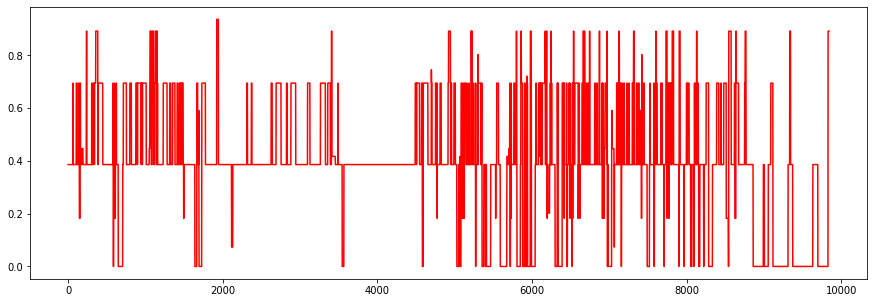

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(polarity_df['polarity'], c='r', label='Real' + ' ' + ticker + ' ' + 'Stock Price')
plt.show()

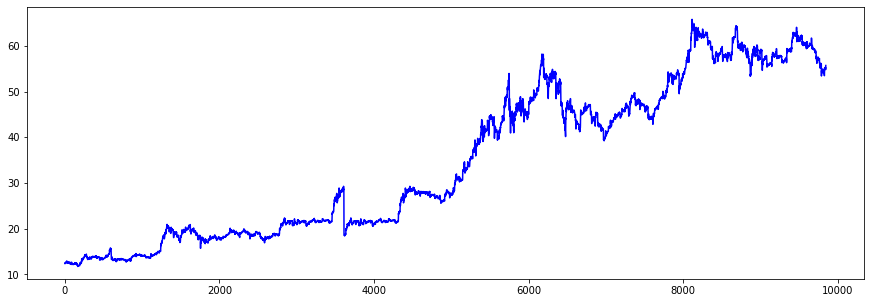

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(df['open'], c='blue', label='Real' + ' ' + ticker + ' ' + 'Stock Price')
plt.show()

In [ ]:
df = pd.concat([df, polarity_df], axis=1).reindex(df.index)
df

,timestamp,open,low,high,volume,close,polarity
0,2020-07-29 08:00:00,12.4000,12.27,12.62,73778.0,12.57,0.386149
1,2020-07-29 08:15:00,12.5700,12.50,12.61,57808.0,12.59,0.386149
2,2020-07-29 08:30:00,12.5800,12.57,12.60,16746.0,12.57,0.386149
3,2020-07-29 08:45:00,12.5700,12.54,12.61,27065.0,12.60,0.386149
4,2020-07-29 09:00:00,12.5900,12.53,12.59,35497.0,12.54,0.386149
...,...,...,...,...,...,...,...
9839,2021-02-19 12:30:00,55.3000,55.01,55.33,45345.0,55.22,0.891852
9840,2021-02-19 12:45:00,55.2200,55.15,55.25,22711.0,55.20,0.891852
9841,2021-02-19 13:00:00,54.8000,54.75,55.73,270333.0,55.51,0.891852
9842,2021-02-19 13:15:00,55.5500,55.50,55.75,94152.0,55.73,0.891852


In [ ]:
x_train, y_train,xv,yv,x_test,y_test, scaler = preprocess_training_data(df)
print(x_train.shape)
print(y_train.shape)
print(xv.shape)
print(yv.shape)
print(x_test.shape)
print(y_test.shape)

(9638, 6, 6)
(9638,)
(100, 6, 6)
(100,)
(100, 6, 6)
(100,)


In [ ]:
save_scaler(ticker)

In [ ]:
model = create_rnn(ticker, x_train, y_train, xv, yv)
train_model(model, x_train, y_train, xv, yv)

Epoch 1/100
252/252 [==============================] - 10s 22ms/step - loss: 0.0607 - val_loss: 0.0035
Epoch 2/100
252/252 [==============================] - 4s 16ms/step - loss: 0.0062 - val_loss: 0.0038
Epoch 3/100
252/252 [==============================] - 4s 16ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 4/100
252/252 [==============================] - 4s 18ms/step - loss: 0.0032 - val_loss: 0.0012
Epoch 5/100
252/252 [==============================] - 5s 18ms/step - loss: 0.0023 - val_loss: 3.4852e-04
Epoch 6/100
252/252 [==============================] - 4s 18ms/step - loss: 0.0022 - val_loss: 6.9693e-04
Epoch 7/100
252/252 [==============================] - 4s 18ms/step - loss: 0.0016 - val_loss: 8.7626e-04
Epoch 8/100
252/252 [==============================] - 4s 17ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 9/100
252/252 [==============================] - 4s 17ms/step - loss: 0.0014 - val_loss: 6.9789e-04
Epoch 10/100
252/252 [==============================] - 4s 17ms/s

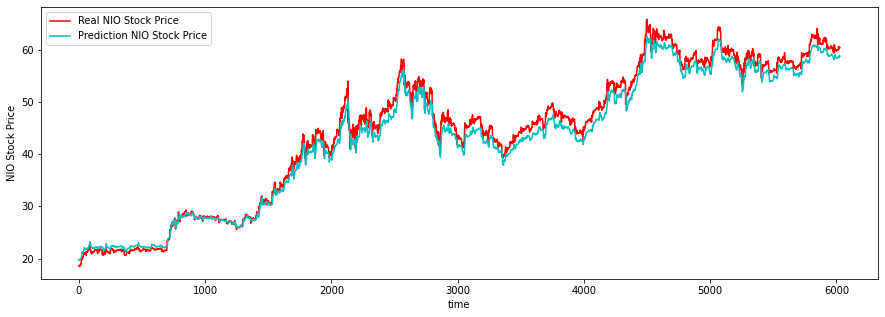

In [ ]:
predictions = model.predict(x_train) * 1/scaler[0]
answers = y_train * 1/scaler[0]
visualize_model(predictions, answers, ticker)

In [ ]:
model.save('Models/' + ticker + time_horizon)

INFO:tensorflow:Assets written to: Models/NIOminute/assets


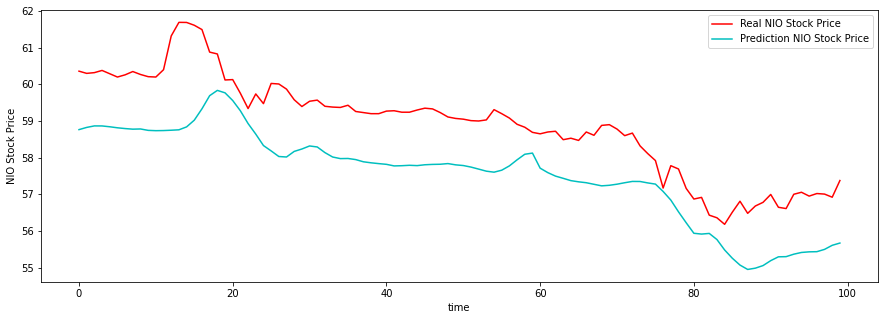

In [ ]:
test_predictions = model.predict(xv) * 1/scaler[0]
test_answers = yv * 1/scaler[0]
visualize_model(test_predictions, test_answers, ticker)

In [ ]:
average = get_average(predictions, answers)
for i in test_predictions:
    i[0] += average

In [ ]:
average

1.5636914126281771

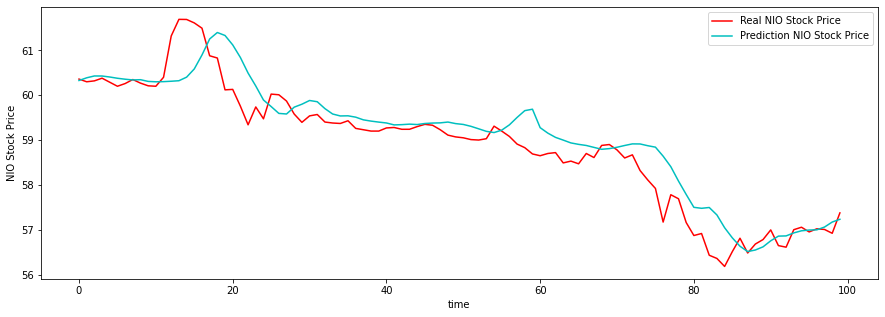

In [ ]:
visualize_model(test_predictions, test_answers, ticker)

In [ ]:
test_predictions2 = model.predict(x_test) * 1/scaler[0]
test_answers2 = y_test * 1/scaler[0]
for i in test_predictions2:
    i[0] += average

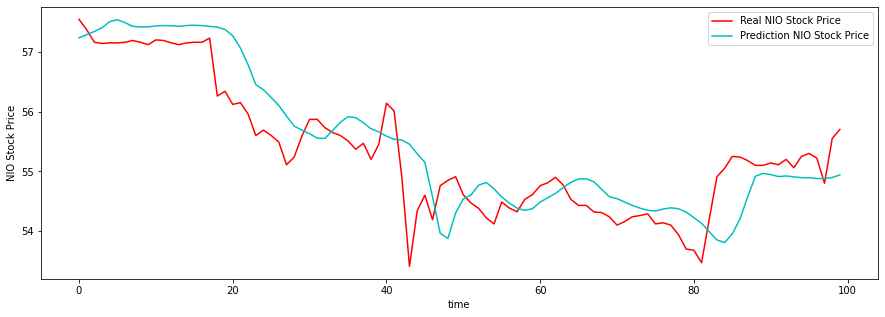

In [ ]:
visualize_model(test_predictions2, test_answers2, ticker)

In [ ]:
trainScore = model.evaluate(x_train, y_train, verbose=0)
testScore = model.evaluate(x_test, y_test, verbose=0)
print(trainScore)
print(testScore)

0.0012235100148245692
0.0010316718835383654


In [ ]:
get_recent_data(ticker, api_key, multiplier, time_horizon)
recent_df, entry_price = update_recent_data(ticker, api_key, multiplier, time_horizon)
recent_df['timestamp'] = recent_df['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
recent_df.tail()

,timestamp,open,low,high,volume,close
187,2021-02-23 23:45:00,49.85,49.85,49.99,28207.0,49.99
188,2021-02-24 00:00:00,49.99,49.93,50.00,45141.0,49.95
189,2021-02-24 00:15:00,49.95,49.95,50.00,50086.0,50.00
190,2021-02-24 00:30:00,50.00,49.95,50.00,48166.0,49.98
191,2021-02-24 00:45:00,49.98,49.95,49.99,65449.0,49.99


In [ ]:
recent_df.head()

,timestamp,open,low,high,volume,close
0,2021-02-19 09:00:00,53.47,53.20,54.09,60885.0,54.09
1,2021-02-19 09:15:00,54.20,54.20,55.10,52715.0,54.91
2,2021-02-19 09:30:00,54.91,54.72,55.01,24711.0,55.01
3,2021-02-19 09:45:00,55.05,55.05,55.32,14606.0,55.29
4,2021-02-19 10:00:00,55.25,55.15,55.25,5473.0,55.24


In [ ]:
entry_price = recent_df.iloc[-1]['open']
entry_price

In [ ]:
news_df = get_recent_news(ticker)
news_df

,datetime,headline,summary
0,2021-02-19 10:01:33,Why NIO Stock's 12-Month Parabolic Rise May No...,NIO stock has enticed investors with great lev...
1,2021-02-19 10:08:00,NIO Stock Is Slumping. There’s Probably Nothin...,American depositary receipts of NIO are down d...
2,2021-02-19 16:49:00,"NIO Inc. ADR rises Friday, outperforms market",The NIO Inc. ADR advanced 1.12% to $55.04 Frid...
3,2021-02-21 11:15:00,"Xiaomi Follows Baidu Into EV-Making, Sparks Fly","Chinese markets were closed for the LNY break,..."
4,2021-02-21 12:01:00,"A Giant Fund Bought EV Stocks NIO and Tesla, a...",Shares of both electric-vehicle makers soared ...
5,2021-02-22 08:11:05,ALPS Clean Energy ETF: Disruptors Of A Megatrend,The ETF includes the most promising disruptors...
6,2021-02-22 12:48:00,China EV Updates: Nio Tests New Power Swap Sta...,Here's the latest news from the growing Chines...
7,2021-02-22 16:49:00,"NIO Inc. ADR falls Monday, underperforms market","The NIO Inc. ADR shed 7.92% to $50.68 Monday, ..."
8,2021-02-22 17:56:00,Tesla Stock Is in a Bear Market. It’s Taking O...,The decline in the stock since its January hig...
9,2021-02-22 21:03:38,Tesla: The Price Of Success And Higher Expecta...,Tesla achieved GAAP profitability for 5 straig...


In [ ]:
polarity_df = combine_news_data(news_df, recent_df)
polarity_df

,polarity
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
123,0.386149
124,0.000000
125,0.000000
126,0.000000


In [ ]:
recent_df = pd.concat([recent_df, polarity_df], axis=1).reindex(recent_df.index)
recent_df.head()

,timestamp,open,low,high,volume,close,polarity
0,2021-02-19 09:00:00,53.47,53.20,54.09,60885.0,54.09,0.0
1,2021-02-19 09:15:00,54.20,54.20,55.10,52715.0,54.91,0.0
2,2021-02-19 09:30:00,54.91,54.72,55.01,24711.0,55.01,0.0
3,2021-02-19 09:45:00,55.05,55.05,55.32,14606.0,55.29,0.0
4,2021-02-19 10:00:00,55.25,55.15,55.25,5473.0,55.24,0.0


In [ ]:
df = preprocess_recent_data(recent_df, scaler)
print(model.predict(df) * 1/scaler[0])
result = get_prediction(model, scaler, df)[0][0] + average
result

[[nan]]


nan

In [ ]:
predictions2 = model.predict(x_test)
for pred in predictions2:
    pred[0] += average

In [ ]:
prob = probablity(predictions2[:-6], y_test[:-6])
print(prob[-1])

In [ ]:
result = get_prediction_details(ticker, api_key, multiplier, time_horizon, result, entry_price)
pprint.pprint(result)

In [ ]:
get_recent_data(ticker, api_key, multiplier, time_horizon)
recent_df, entry_price = update_recent_data(ticker, api_key, multiplier, time_horizon)
recent_df['timestamp'] = recent_df['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))
recent_df = recent_df[150:177] 
recent_df.tail()

,timestamp,open,low,high,volume,close
172,2021-02-23 20:00:00,47.8000,47.38,48.44,2617024.0,48.4400
173,2021-02-23 20:15:00,48.4300,48.32,49.54,4592954.0,49.4101
174,2021-02-23 20:30:00,49.4300,49.16,49.67,3421473.0,49.3401
175,2021-02-23 20:45:00,49.3445,48.92,49.56,3603603.0,49.1084
176,2021-02-23 21:00:00,49.1100,48.92,49.38,122820.0,48.9900


In [ ]:
recent_df.head()

,timestamp,open,low,high,volume,close
150,2021-02-23 14:30:00,45.62,41.6600,46.50,29282852.0,43.1900
151,2021-02-23 14:45:00,43.20,41.9300,45.67,14864956.0,45.2831
152,2021-02-23 15:00:00,45.29,45.2701,47.32,12261642.0,46.4700
153,2021-02-23 15:15:00,46.47,45.4200,47.80,8711603.0,47.4532
154,2021-02-23 15:30:00,47.47,46.8100,48.17,7117675.0,47.9885


In [ ]:
news_df = get_recent_news(ticker)
news_df.head()

,datetime,headline,summary
0,2021-02-23 06:25:00,Lucid Motors Is Going Public. The Merger Partn...,EV start up Lucid Motors has finally agreed to...
1,2021-02-23 00:00:00,"EV Stock Slide: Why Nio, Xpeng, Li Auto Shares...",The U.S.-listed ADSs of Chinese EV manufacture...
2,2021-02-22 21:03:38,Tesla: The Price Of Success And Higher Expecta...,Tesla achieved GAAP profitability for 5 straig...
3,2021-02-22 17:56:00,Tesla Stock Is in a Bear Market. It’s Taking O...,The decline in the stock since its January hig...
4,2021-02-22 16:49:00,"NIO Inc. ADR falls Monday, underperforms market","The NIO Inc. ADR shed 7.92% to $50.68 Monday, ..."


In [ ]:
news_df = combine_news_data(news_df, recent_df)
news_df

In [ ]:
recent_df = pd.concat([recent_df, news_df], axis=1).reindex(recent_df.index)

In [ ]:
training_df = recent_df.drop(['timestamp'], axis=1)
training_df['open'] *= scaler[0]
training_df['low'] *= scaler[1]
training_df['high'] *= scaler[2]
training_df['volume'] *= scaler[3]
training_df['close'] *= scaler[4]

x_train, y_train = [], []
training_df = np.asarray(training_df)
for i in range(6, training_df.shape[0]):
    x_train.append(training_df[i - 6: i])
    y_train.append(training_df[i, 0])
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
print(x_train.shape)
print(y_train.shape)

In [ ]:
incorrect, correct = 0, 0
predictions = model.predict(x_train) * 1/scaler[0]
answers = y_train * 1/scaler[0]

In [ ]:
for i in range(1, x_train.shape[0]):
    if ((predictions[i] + average - answers[i - 1] > 0) and (answers[i]  - answers[i - 1]) > 0) or ((predictions[i] + average - answers[i - 1]) < 0 and (answers[i]  - answers[i - 1]) < 0):
        correct += 1
        print('correct: ' + 'prediction: ' + str(round(predictions[i][0] + average, 4)) +  ' actual: ' + str(round(answers[i], 4)) + ' previous: ' + str(round(answers[i - 1], 4)))

In [ ]:
for i in range(1, x_train.shape[0]):
    if ((predictions[i] + average - answers[i - 1] > 0) and (answers[i]  - answers[i - 1]) < 0) or ((predictions[i] + average - answers[i - 1]) < 0 and (answers[i]  - answers[i - 1]) > 0):
        incorrect += 1
        print('incorrect: ' + 'prediction: ' + str(round(predictions[i][0] + average, 4)) +  ' actual: ' + str(round(answers[i], 4)) + ' previous: ' + str(round(answers[i - 1], 4)))

In [ ]:
print('Correct: ' + str(correct))
print('Incorrect: ' + str(incorrect))
print('Accuracy: ' + str(round(correct/(incorrect + correct), 4)))

In [ ]:
money = 100
stocks = 0
invest = False
for i in range(1, x_train.shape[0]):
    if not invest:
        if predictions[i] + average - answers[i - 1] > 0:
            invest = True
            stocks = 100/answers[i - 1]
    elif predictions[i] + average - answers[i - 1] > 0 and invest:
        money = stocks * answers[i - 1]
        invest = False

In [ ]:
print(stocks * answers[-1]) if invest else print(money)

In [ ]:
for i in predictions:
    i += average

In [ ]:
visualize_model(predictions, answers, ticker)

In [ ]:
model.save('Models/'+ ticker + time_horizon)

**Real Time Predictions**


---



In [ ]:
while True:
    get_recent_data(ticker, api_key,multiplier, time_horizon)
    recent_df, entry_price = update_recent_data(ticker, api_key, multiplier, time_horizon)
    recent_df['timestamp'] = recent_df['timestamp'].apply(lambda x:datetime.fromtimestamp(x/1000))

    news_df = get_recent_news(ticker)
    news_df = combine_news_data(news_df, recent_df)
    recent_df = pd.concat([recent_df, news_df], axis=1).reindex(recent_df.index)

    training_df = recent_df.drop(['timestamp'], axis=1)
    training_df['open'] *= scaler[0]
    training_df['low'] *= scaler[1]
    training_df['high'] *= scaler[2]
    training_df['volume'] *= scaler[3]
    training_df['close'] *= scaler[4]
    
    entry_price = training_df.iloc[-1].iloc[0] * 1/scaler[0]
    training_df = [training_df]
    training_df = np.asarray(training_df)

    prediction = model.predict(training_df) * 1/scaler[0] + average
    result = get_prediction_details(ticker, api_key, 15, 'minute', prediction[0][0], entry_price)
    pprint.pprint(result)
    time.sleep(900)